In [1]:
from IPython.core.display import display, HTML

# Implementation of the SPT Model 
## Develop Version

This notebook aims to create a dataset that follows the SZ-scaling relation fitted on Bocquet et al. 2019.

Modifications: Johnny Esteves <br>
Author: Allen Pinjic - Created on June 21st, 2022

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [4]:
# sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [5]:
sns.set_context('poster',font_scale=0.8)
sns.set_style('whitegrid')

In [6]:
%matplotlib inline

# Make Simulated Data

In [32]:
Nclusters = 1500
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79

In [33]:
# the SZ sample is complete for mass down up to 10E14
h = 0.7
N0 = 100000
mfakes = 10**(np.random.uniform(14.2, 15.2, size=N0))
zfakes = np.random.uniform(0.1, 1.3, size=N0)

In [34]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [35]:
p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(N0, size = Nclusters, p = (p_halos/(np.sum(p_halos))),replace=True)
# size = Nclusters/100 or 100,000/100 = 1000

In [36]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to exponential
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [37]:
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)
#mean = [lbd_true, zeta_true]

In [38]:
M0 = 3e14
Ez0 = E(0)
# Ez2 = interpolate.interp1d(zvec, E(zvec), kind='cubic')
# NEEDED? CUBIC?

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

In [39]:
# apply a cut on the lnZeta_true
cut = np.where(np.sqrt(np.exp(ln_zeta_true)**2+3)>3.0)[0]
Nclusters2 = len(cut)

In [40]:
Nclusters2

1302

In [41]:
mu_actual = np.array([0., 0.])
sigmas_actual = np.array([sigma_lbd,sigma_chisi])
Rho_actual = np.matrix([[1.0, rho], [rho, 1.0]])

Sigma_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

Res = np.random.multivariate_normal(mu_actual, Sigma_actual, size=Nclusters2)
Sigma_actual

matrix([[0.028561, 0.021632],
        [0.021632, 0.0256  ]])

In [42]:
np.corrcoef(Res.T)

array([[1.        , 0.78990149],
       [0.78990149, 1.        ]])

Text(0,0.5,'zeta residuals')

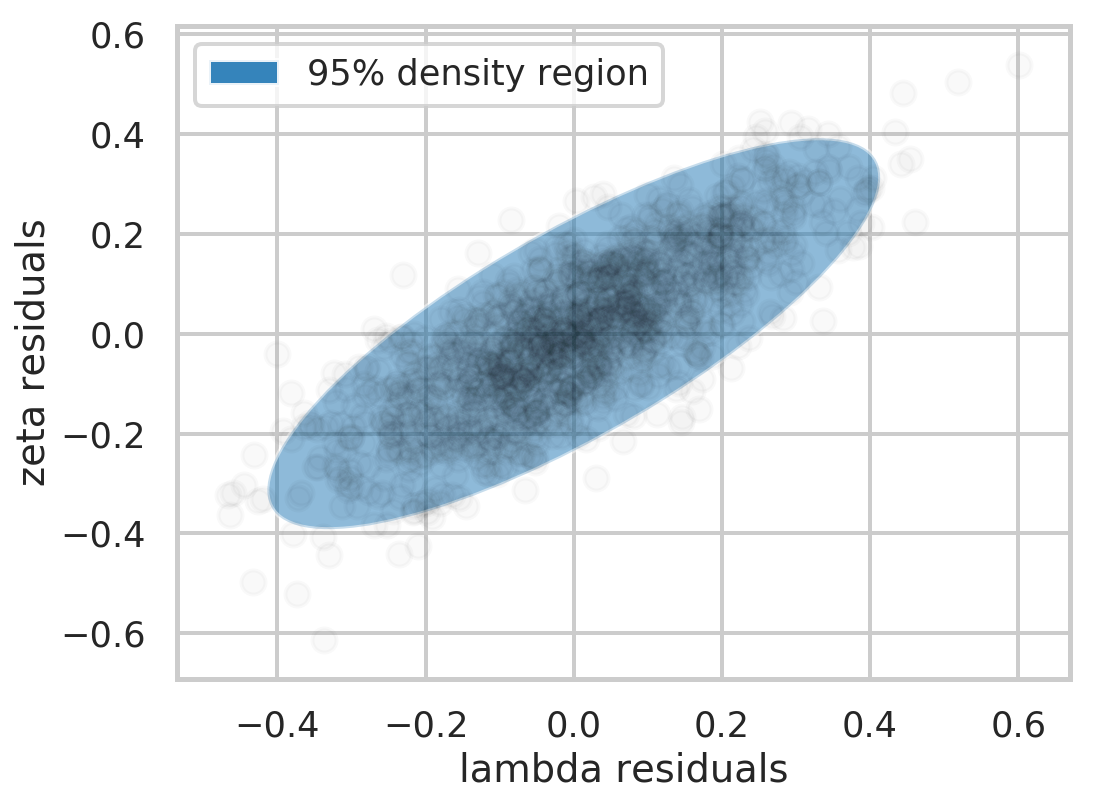

In [43]:
from matplotlib.patches import Ellipse

var, U = np.linalg.eig(Sigma_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(Res[:, 0], Res[:, 1], c="k", alpha=0.025, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.9)
ax.legend([rect], ["95% density region"], loc=2);
ax.set_xlabel('lambda residuals')
ax.set_ylabel('zeta residuals')

In [44]:
Xtrue = np.vstack([ln_lambda_true[cut],ln_zeta_true[cut]]).T
np.exp(Xtrue)

array([[ 64.15586562,   4.01256822],
       [ 48.55710554,   2.62913923],
       [ 59.38961279,   3.59191347],
       ...,
       [121.54155518,  10.50195676],
       [ 50.41890929,   2.79214028],
       [ 57.2350416 ,   3.3660897 ]])

In [45]:
Xobs = Xtrue+Res

In [46]:
ln_zeta = Xobs[:,1]
ln_lambda = Xobs[:,0]

lambda_errors = 0.10*np.sqrt(np.exp(ln_lambda))*np.sqrt(40.)
_lambda = np.exp(ln_lambda) #np.array([np.exp(ln_li) #+ np.random.normal(scale=lie) for ln_li, lie in zip(ln_lambda,lambda_errors)])

In [47]:
out = dict()
out['z'] = zsims[cut]
out['M'] = msims[cut]
out['lambda'] = _lambda
out['lambda_error'] = lambda_errors
out['lambda_wo_noise'] = np.exp(ln_lambda)
out['zeta'] = np.exp(ln_zeta)
out['chisi'] = np.sqrt(np.exp(ln_zeta)**2+3)#+np.random.normal(size=len(ln_zeta))
out['lambda_true'] = np.exp(ln_lambda_true[cut])
out['zeta_true'] = np.exp(ln_zeta_true[cut])
out['res_lambda'] = np.exp(ln_lambda)-out['lambda_true']
out['res_zeta'] = out['zeta']-out['zeta_true']

df = pd.DataFrame(out, columns = ['z', 'M', 'lambda', 'chisi', 'zeta', 'lambda_error', 'lambda_wo_noise', 'lambda_true', 'zeta_true', 'res_lambda', 'res_zeta'])

In [48]:
## apply thresholds 

df0 = df.copy()
chisi = df0['chisi'].to_numpy()
Lambda = df0['lambda'].to_numpy()
zetacut = (Lambda>5.)& (chisi>4.5)
df = df0.loc[zetacut].copy()

display(df.describe())

,z,M,lambda,chisi,zeta,lambda_error,lambda_wo_noise,lambda_true,zeta_true,res_lambda,res_zeta
count,664.000000,6.640000e+02,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.396483,3.647055e+14,103.576377,8.707134,8.488528,6.328282,103.576377,99.394309,8.177578,4.182068,0.310950
std,0.235900,1.468267e+14,42.960802,5.714515,5.780648,1.177064,42.960802,39.942125,5.659563,18.972736,1.583301
min,0.101177,1.773573e+14,45.705280,4.500568,4.153927,4.275759,45.705280,48.619541,2.649924,-61.408976,-9.333238
25%,0.215263,2.703275e+14,75.593317,5.341386,5.052762,5.498848,75.593317,74.203815,4.998488,-7.285917,-0.491497
50%,0.335305,3.229946e+14,90.264668,6.852825,6.630325,6.008813,90.264668,87.648512,6.402938,3.257122,0.270306
75%,0.519558,4.098379e+14,119.551647,9.948726,9.796793,6.915248,119.551647,112.758132,9.407408,13.771514,1.037053
max,1.290893,1.552731e+15,466.840694,70.666608,70.645378,13.665148,466.840694,421.621568,67.888021,83.437039,10.348435


In [49]:
f=lambda x,a,b: a*x + b
def plot_linear_fit(x,y):
    fit=curve_fit(f, x, y)
    xsmooth=np.linspace(x.min(), x.max(), 1000)
    label_coefs = 'slope = {:.5f} \nintercept = {:.5f}'.format(*fit[0])
    plt.plot(xsmooth,f(xsmooth,*fit[0]),'r-',linewidth=3,label=label_coefs)

Text(0.5,1,'With $\\zeta$  Threshold')

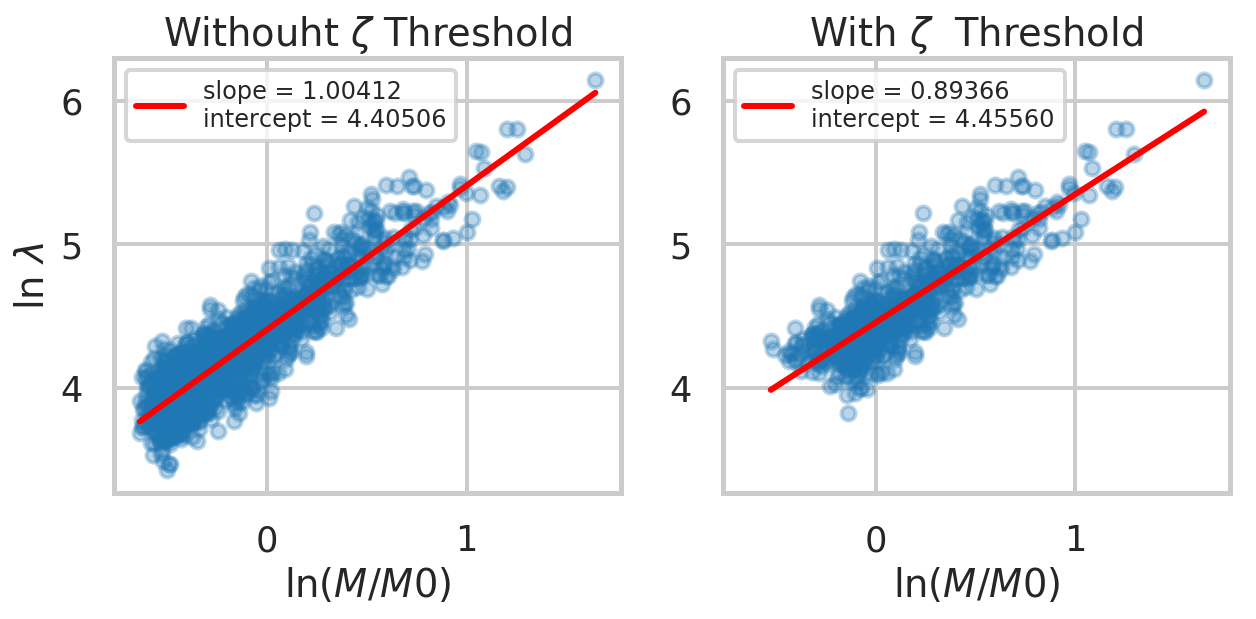

In [50]:
# without threshold
x = np.log(df0['M'].to_numpy()/M0)
y = np.log(df0['lambda'].to_numpy())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)
plt.ylabel(r'ln $\lambda$')
plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.title(r'Withouht $\zeta$ Threshold')
xmin, xmax, ymin, ymax = plt.axis()

# with threshold
x = np.log(df['M'].to_numpy()/M0)
y = np.log(df['lambda'].to_numpy())

plt.subplot(1, 2, 2)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)

plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(r'With $\zeta$  Threshold')

Text(0.5,1,'With $\\zeta$  Threshold')

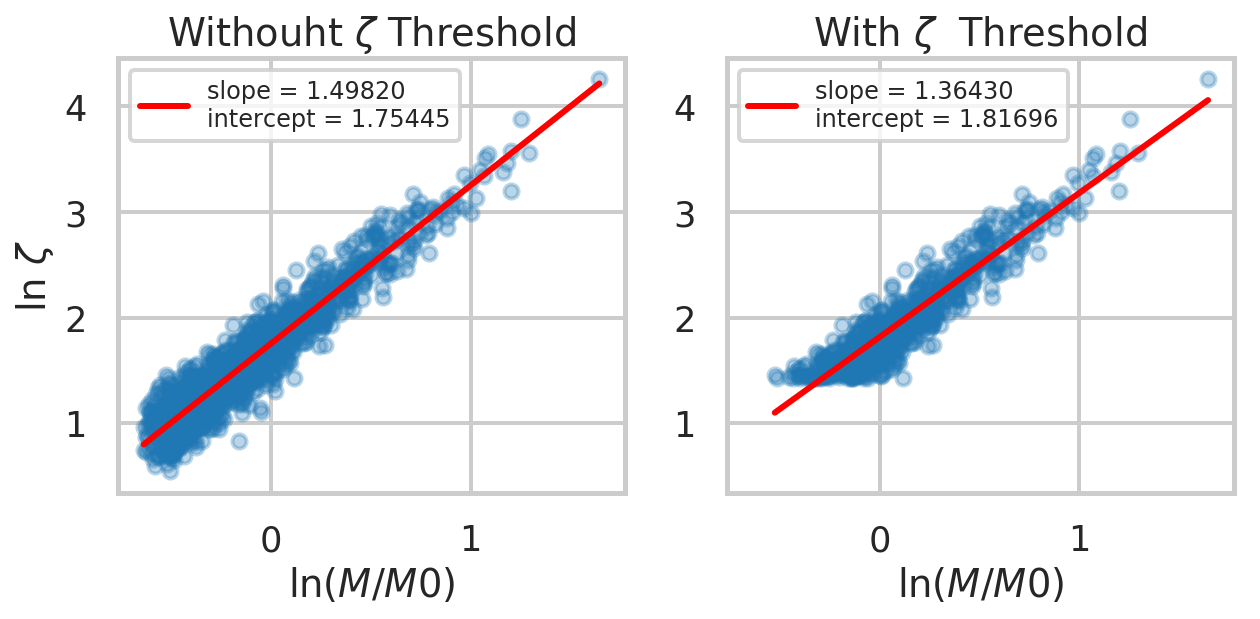

In [51]:
# without threshold
x = np.log(df0['M'].to_numpy()/M0)
y = np.log(df0['zeta'].to_numpy())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)
plt.ylabel(r'ln $\zeta$')
plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.title(r'Withouht $\zeta$ Threshold')
xmin, xmax, ymin, ymax = plt.axis()

# with threshold
x = np.log(df['M'].to_numpy()/M0)
y = np.log(df['zeta'].to_numpy())

plt.subplot(1, 2, 2)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)

plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(r'With $\zeta$  Threshold')

Text(0.5,1,'With $\\zeta$  Threshold')

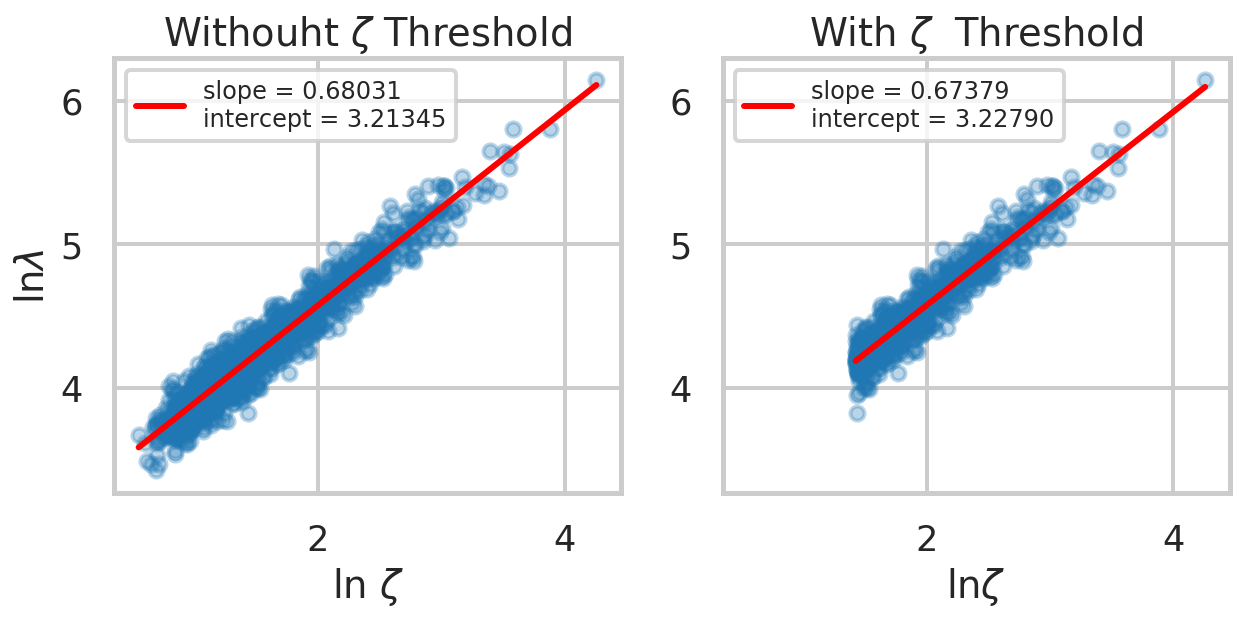

In [52]:
# without threshold
x = np.log(df0['zeta'].to_numpy())
y = np.log(df0['lambda'].to_numpy())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)
plt.xlabel(r'ln $\zeta$')
plt.ylabel(r'ln$\lambda$')
plt.legend(fontsize=12)
plt.title(r'Withouht $\zeta$ Threshold')
xmin, xmax, ymin, ymax = plt.axis()

# with threshold
x = np.log(df['zeta'].to_numpy())
y = np.log(df['lambda'].to_numpy())

plt.subplot(1, 2, 2)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)

plt.xlabel(r'ln$\zeta$')
plt.legend(fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(r'With $\zeta$  Threshold')

Text(0.5,0,'$\\lambda$')

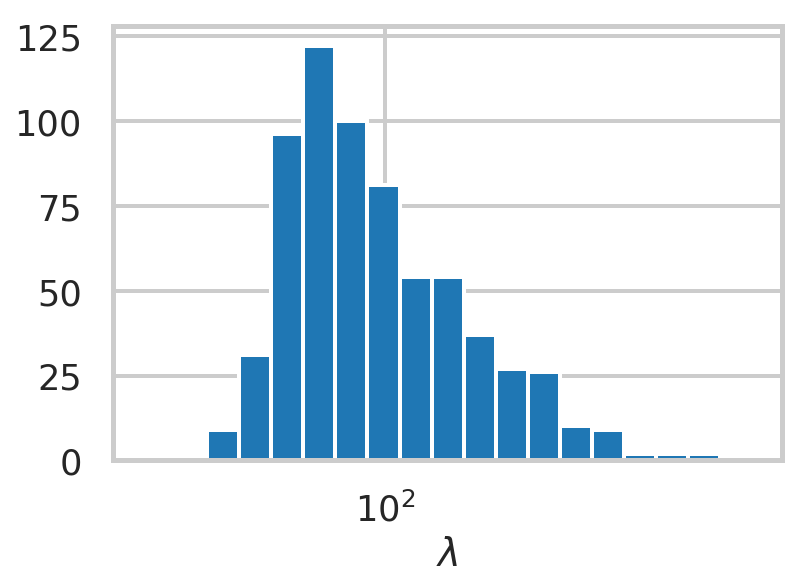

In [53]:
plt.figure(figsize=(6,4))
# plt.subplot(1, 2, 1)
plt.hist(df['lambda'],bins=np.logspace(np.log10(40),np.log10(400),20))
plt.xscale('log')
plt.xlabel(r'$\lambda$')

In [54]:
df.corr()

,z,M,lambda,chisi,zeta,lambda_error,lambda_wo_noise,lambda_true,zeta_true,res_lambda,res_zeta
z,1.000000,-0.247659,-0.154337,-0.140150,-0.140918,-0.163750,-0.154337,-0.167558,-0.150613,0.003278,0.023879
M,-0.247659,1.000000,0.894785,0.943211,0.944320,0.881045,0.894785,0.996285,0.984101,-0.071317,-0.069980
lambda,-0.154337,0.894785,1.000000,0.948942,0.950162,0.989477,1.000000,0.897767,0.891332,0.374331,0.282955
chisi,-0.140150,0.943211,0.948942,1.000000,0.999964,0.914919,0.948942,0.947647,0.961936,0.153708,0.212408
zeta,-0.140918,0.944320,0.950162,0.999964,1.000000,0.917202,0.950162,0.948743,0.961912,0.154164,0.212624
lambda_error,-0.163750,0.881045,0.989477,0.914919,0.917202,1.000000,0.989477,0.883556,0.859224,0.380420,0.277388
lambda_wo_noise,-0.154337,0.894785,1.000000,0.948942,0.950162,0.989477,1.000000,0.897767,0.891332,0.374331,0.282955
lambda_true,-0.167558,0.996285,0.897767,0.947647,0.948743,0.883556,0.897767,1.000000,0.988333,-0.072384,-0.068961
zeta_true,-0.150613,0.984101,0.891332,0.961936,0.961912,0.859224,0.891332,0.988333,1.000000,-0.062395,-0.062584
res_lambda,0.003278,-0.071317,0.374331,0.153708,0.154164,0.380420,0.374331,-0.072384,-0.062395,1.000000,0.785887


In [55]:
df0.corr()

,z,M,lambda,chisi,zeta,lambda_error,lambda_wo_noise,lambda_true,zeta_true,res_lambda,res_zeta
z,1.000000,-0.235500,-0.152639,-0.139956,-0.140852,-0.156554,-0.152639,-0.160621,-0.146075,-0.017779,-0.001503
M,-0.235500,1.000000,0.923784,0.951824,0.954399,0.906288,0.923784,0.996668,0.981688,0.048307,0.042190
lambda,-0.152639,0.923784,1.000000,0.953893,0.957226,0.986390,1.000000,0.926559,0.910434,0.419861,0.335331
chisi,-0.139956,0.951824,0.953893,1.000000,0.999804,0.910488,0.953893,0.955673,0.970177,0.227176,0.274204
zeta,-0.140852,0.954399,0.957226,0.999804,1.000000,0.916698,0.957226,0.958257,0.969957,0.229792,0.275877
lambda_error,-0.156554,0.906288,0.986390,0.910488,0.916698,1.000000,0.986390,0.908836,0.869724,0.426482,0.329680
lambda_wo_noise,-0.152639,0.923784,1.000000,0.953893,0.957226,0.986390,1.000000,0.926559,0.910434,0.419861,0.335331
lambda_true,-0.160621,0.996668,0.926559,0.955673,0.958257,0.908836,0.926559,1.000000,0.985437,0.047636,0.043229
zeta_true,-0.146075,0.981688,0.910434,0.970177,0.969957,0.869724,0.910434,0.985437,1.000000,0.039958,0.033755
res_lambda,-0.017779,0.048307,0.419861,0.227176,0.229792,0.426482,0.419861,0.047636,0.039958,1.000000,0.786164


In [56]:
df0.to_csv(r'fake_data_Jul4.csv', index=False)

In [57]:
len(df0)

1302